In [1]:
"""
created by Arj at 16:28 BST

Investigating the challenge notebook and running it's code. 
"""

import matplotlib.pyplot as plt
import numpy as np

from qctrlvisualizer import get_qctrl_style, plot_controls
from qctrl import Qctrl

qctrl = Qctrl()

In [2]:
def simulate_ideal_qubit(
    duration=1, values=np.array([np.pi]), shots=1024, repetitions=1
):

    b = np.array([[0, 1], [0, 0]])  # Lowering operator
    initial_state = np.array([[1], [0]])  # Initial state of qubit in |0>

    with qctrl.create_graph() as graph:

        # Create time dependent \Omega(t)
        drive = qctrl.operations.pwc_signal(duration=duration, values=values)

        # Construct Hamiltonian (\Omega(t) b + \Omega^*(t) b^\dagger)/2
        hamiltonian = qctrl.operations.pwc_operator_hermitian_part(
            qctrl.operations.pwc_operator(signal=drive, operator=b)
        )

        # Solve Schrodinger's equation and get total unitary at the end
        unitary = qctrl.operations.time_evolution_operators_pwc(
            hamiltonian=hamiltonian,
            sample_times=np.array([duration]),
        )[-1]
        unitary.name = "unitary"

        # Repeat final unitary
        repeated_unitary = np.eye(2)
        for _ in range(repetitions):
            repeated_unitary = repeated_unitary @ unitary
        repeated_unitary.name = "repeated_unitary"

        # Calculate final state.
        state = repeated_unitary @ initial_state

        # Calculate final populations.
        populations = qctrl.operations.abs(state[:, 0]) ** 2
        # Normalize populations because of numerical precision
        norm = qctrl.operations.sum(populations)
        populations = populations / norm
        populations.name = "populations"

    # Evaluate graph.
    result = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=["unitary", "repeated_unitary", "populations"],
    )

    # Extract outputs.
    unitary = result.output["unitary"]["value"]
    repeated_unitary = result.output["repeated_unitary"]["value"]
    populations = result.output["populations"]["value"]

    # Sample projective measurements.
    measurements = np.random.choice(2, size=shots, p=populations)

    results = {"unitary": unitary, "measurements": measurements}

    return results


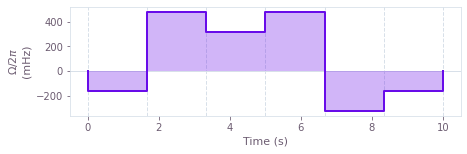

In [3]:
duration = 10
values = np.array([-1, 3, 2, 3, -2, -1])


def get_pulse_plot_dict(name="default", duration=1, values=np.array([1.0])):
    segments = len(values)
    segment_durations = duration / segments
    pulse_plot_dict = {
        name: [{"duration": segment_durations, "value": v} for v in values]
    }
    return pulse_plot_dict


example_pulse = get_pulse_plot_dict(name="$\Omega$", duration=duration, values=values)

fig = plt.figure()
plot_controls(fig, example_pulse, polar=False)
plt.show()


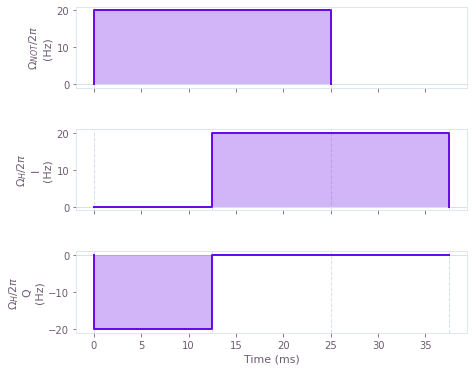

In [4]:
max_rabi_rate = 20 * 2 * np.pi  # MHz
not_duration = np.pi / (max_rabi_rate)  # us
not_values = np.array([max_rabi_rate])
h_duration = 3 * np.pi / (2 * max_rabi_rate)  # us
h_values = np.array([-1j * max_rabi_rate, max_rabi_rate, max_rabi_rate])

not_pulse = get_pulse_plot_dict(
    name="$\Omega_{NOT}$", duration=not_duration, values=not_values
)
h_pulse = get_pulse_plot_dict(name="$\Omega_{H}$", duration=h_duration, values=h_values)
both_pulses = {**not_pulse, **h_pulse}

fig = plt.figure()
plot_controls(fig, both_pulses, polar=False)
plt.show()

In [5]:
shots = 1024
not_results = simulate_ideal_qubit(
    duration=not_duration, values=not_values, shots=shots
)
h_results = simulate_ideal_qubit(duration=h_duration, values=h_values, shots=shots)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


In [6]:
error_norm = (
    lambda operate_a, operator_b: 1
    - np.abs(np.trace((operate_a.conj().T @ operator_b)) / 2) ** 2
)

realised_not_gate = not_results["unitary"]
ideal_not_gate = np.array([[0, 1], [1, 0]])
not_error = error_norm(realised_not_gate, ideal_not_gate)
realised_h_gate = h_results["unitary"]
ideal_h_gate = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
h_error = error_norm(realised_h_gate, ideal_h_gate)

print("Realised NOT Gate:")
print(realised_not_gate)
print("Ideal NOT Gate:")
print(ideal_not_gate)
print("NOT Gate Error:" + str(not_error) + "\n")
print("Realised H Gate:")
print(realised_h_gate)
print("Ideal H Gate:")
print(ideal_h_gate)
print("H Gate Error:" + str(h_error))


Realised NOT Gate:
[[2.83276945e-16+0.j 0.00000000e+00-1.j]
 [0.00000000e+00-1.j 2.83276945e-16+0.j]]
Ideal NOT Gate:
[[0 1]
 [1 0]]
NOT Gate Error:4.440892098500626e-16

Realised H Gate:
[[ 2.22044605e-16-0.70710678j -2.22044605e-16-0.70710678j]
 [ 2.22044605e-16-0.70710678j  2.22044605e-16+0.70710678j]]
Ideal H Gate:
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
H Gate Error:1.1102230246251565e-15


In [7]:
not_measurements = not_results["measurements"]
h_measurements = h_results["measurements"]


def estimate_probability_of_one(measurements):
    size = len(measurements)
    probability = np.mean(measurements)
    standard_error = np.std(measurements) / np.sqrt(size)
    return (probability, standard_error)


not_probability, not_standard_error = estimate_probability_of_one(not_measurements)
h_probability, h_standard_error = estimate_probability_of_one(h_measurements)

print("NOT estimated probability of getting 1:" + str(not_probability))
print("NOT estimate standard error:" + str(not_standard_error))
print("H estimated probability of getting 1:" + str(h_probability))
print("H estimate standard error:" + str(h_standard_error))


NOT estimated probability of getting 1:1.0
NOT estimate standard error:0.0
H estimated probability of getting 1:0.4931640625
H estimate standard error:0.0156235396179561


In [8]:
epsilon = 0.003
h_duration = (np.pi + epsilon) / (2 * max_rabi_rate)  # us

repetitions = np.array([1, 17, 127])
repetition_results = []


In [9]:
for reps in repetitions:
    repetition_results.append(
        simulate_ideal_qubit(
            duration=h_duration, values=values, shots=shots, repetitions=reps
        )
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_graph has completed in 3s.


In [10]:
probability_estimates = np.zeros(3)
standard_errors = np.zeros(3)

for count, result in enumerate(repetition_results):
    probability_estimates[count], standard_errors[count] = estimate_probability_of_one(
        result["measurements"]
    )


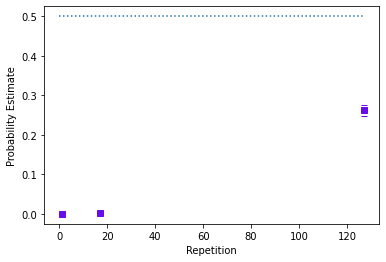

In [11]:
plt.plot(repetitions, probability_estimates, "s", color="#680CE9")
plt.plot(repetitions, probability_estimates + standard_errors, "_", color="#680CE9")
plt.plot(repetitions, probability_estimates - standard_errors, "_", color="#680CE9")
plt.hlines(0.5, 0, 127, linestyle=":")
plt.xlabel("Repetition")
plt.ylabel("Probability Estimate")
plt.show()


In [12]:
repetitions

array([  1,  17, 127])

In [13]:
probability_estimates

array([0.        , 0.00292969, 0.26171875])